# 2025-03-05 Runge-Kutta

## Last time

* Advection-diffusion
* $A$- and $L$-stability
* Spatial, temporal, and physical dissipation
* Stiffness

## Today
* Exploring stiffness
* Runge-Kutta methods

In [40]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function plot_stability(Rz, title; xlims=(-3, 3), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end

function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)

function advdiff_matrix(n; kappa=1, wind=1, upwind=0.)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.(i-1:i+1))
        diffuse = [-1, 2, -1] * kappa / dx^2
        advect_upwind = [-1, 1, 0] * wind / dx
        advect_center = [-1, 0, 1] * wind / 2dx
        stencil = -diffuse - upwind * advect_upwind - (1 - upwind) * advect_center
        append!(vals, stencil)
    end
    sparse(rows, cols, vals)
end
advdiff_matrix(5, kappa=.1)

5×5 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 -1.25   -0.625    ⋅       ⋅      1.875
  1.875  -1.25   -0.625    ⋅       ⋅ 
   ⋅      1.875  -1.25   -0.625    ⋅ 
   ⋅       ⋅      1.875  -1.25   -0.625
 -0.625    ⋅       ⋅      1.875  -1.25

# Stiffness

> Stiff equations are problems for which explicit methods don't work. (Hairer and Wanner, 2002)

* "stiff" dates to Curtiss and Hirschfelder (1952)

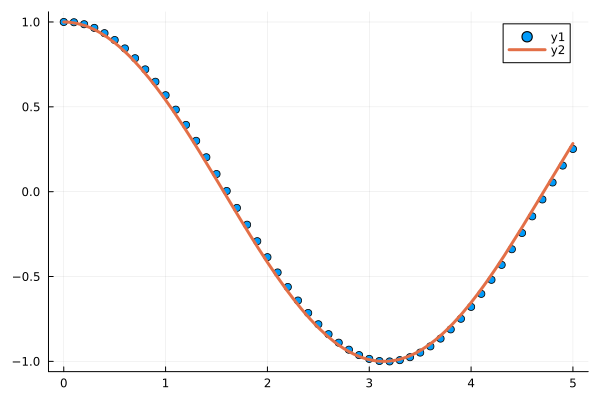

In [41]:
k = 30
thist, uhist = ode_theta_linear(-k, [1.0], forcing=t -> k*cos(t), tfinal=5, h=.1, theta=0.5)
scatter(thist, uhist[1,:])
plot!(cos)

In [42]:
function mms_error(h; theta=.5, k=10)
    u0 = [.2]
    thist, uhist = ode_theta_linear(-k, u0, forcing=t -> k*cos(t), tfinal=3, h=h, theta=theta)
    T = thist[end]
    u_exact = (u0 .- k^2/(k^2+1)) * exp(-k*T) .+ k*(sin(T) + k*cos(T))/(k^2 + 1)
    uhist[1,end] .- u_exact
end

mms_error (generic function with 1 method)

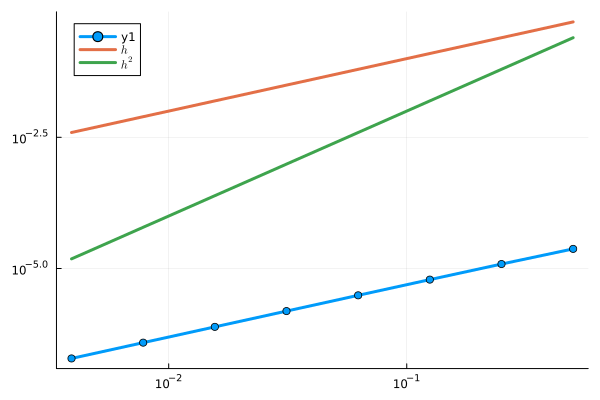

In [43]:
hs = .5 .^ (1:8)
errors = mms_error.(hs, theta=1, k=10000)
plot(hs, norm.(errors), marker=:circle, xscale=:log10, yscale=:log10)
plot!(hs, hs, label="\$h\$", legend=:topleft)
plot!(hs, hs.^2, label="\$h^2\$")


## Discuss: is advection-diffusion stiff?

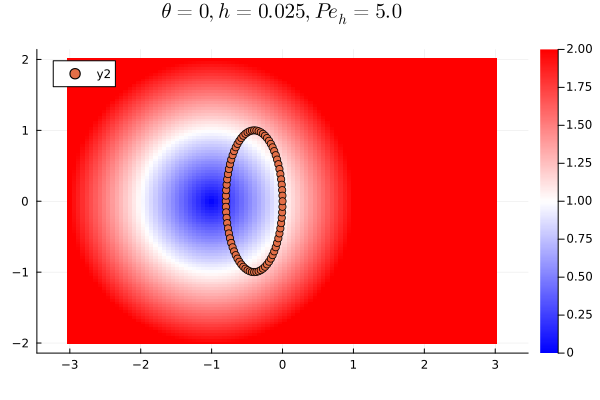

In [44]:
theta=0
n = 80
dx = 2 / n
kappa = .005
lambda_min = -4 * kappa / dx^2
cfl = 1
h = min(-2 / lambda_min, cfl * dx)

plot_stability(z -> Rz_theta(z, theta),
    "\$\\theta=$theta, h=$h, Pe_h = $(h/kappa)\$")
ev = eigvals(Matrix(h*advdiff_matrix(n, kappa=kappa, wind=1)))
scatter!(real(ev), imag(ev))

# Cost scaling

* Spatial discretization with error $O((\Delta x)^p)$
* Time discretization with error $O((\Delta t)^q)$

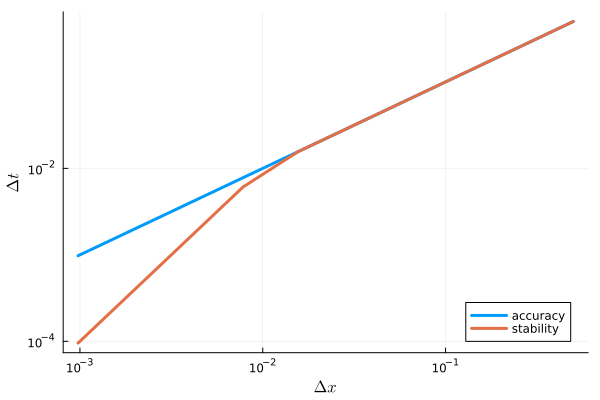

In [45]:
p = 2   # spatial order of accuracy
q = 2   # temporal order of accuracy
Pe = 100 # Peclet number with wind=1

dt_accuracy(dx) = dx .^ (p/q)
dt_stability(dx) = min(dx, Pe * dx ^ 2)

n = 2 .^ (1:10); dx = 1 ./ n
plot(dx, [dt_accuracy.(dx) dt_stability.(dx)],
    label=["accuracy" "stability"], 
    xscale=:log10, yscale=:log10, legend=:bottomright,
    xlabel="\$\\Delta x\$", ylabel="\$\\Delta t\$")

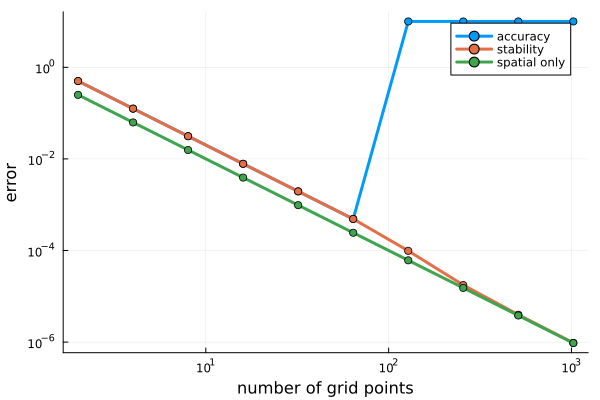

In [46]:
function error((dx, dt))
    dt <= dt_stability(dx) ? dx ^ p + dt ^ q : 10
end
plot(n, [error.(zip(dx, dt_accuracy.(dx))) error.(zip(dx, dt_stability.(dx))) dx.^p],
    label=["accuracy" "stability" "spatial only"],
    marker=:circle, xscale=:log10, yscale=:log10,
    xlabel="number of grid points", ylabel="error")

# Work-precision (error vs cost)

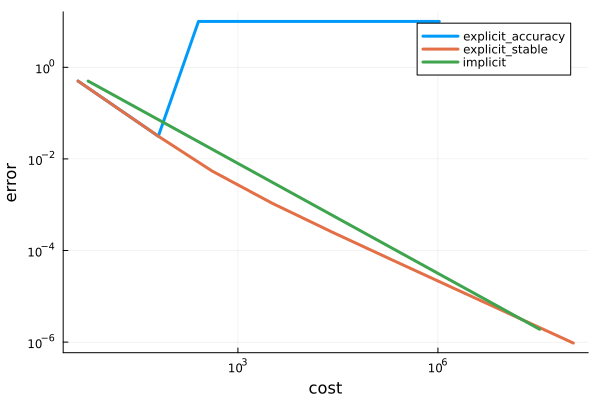

In [47]:
p = 2
q = 2
Pe = 10
dt = [dt_accuracy.(dx) dt_stability.(dx) dt_accuracy.(dx)]
c = [n./dt[:,1] n./dt[:,2] (n.^1.5)./dt[:,3]] # O(n^1.5 solve cost)
e = [error.(zip(dx, dt[:,1])) error.(zip(dx, dt[:,2])) dx.^p+dt[:,3].^q]
plot(c, e, xscale=:log10, yscale=:log10,
  label=["explicit_accuracy" "explicit_stable" "implicit"], xlabel="cost", ylabel="error")

* Stability can be an extreme demand for explicit methods
* Order of accuracy matters; usually balance spatial order $p$ and temporal order $q$
* Actual cost depends heavily on solver efficiency: O(n) vs O(n^2)
* "Constants matter"

# Runge-Kutta methods

The methods we have considered thus far can all be expressed as Runge-Kutta methods, which are expressed in terms of $s$ "stage" equations (possibly coupled) and a completion formula.  For the ODE

$$ \dot u = f(t, u) $$

the Runge-Kutta method is

$$\begin{split}
Y_i = u(t) + h \sum_j a_{ij} f(t+c_j h, Y_j) \\
u(t+h) = u(t) + h \sum_j b_j f(t+c_j h, Y_j)
\end{split}$$
where $c$ is a vector of *abscissa*, $A$ is a table of coefficients, and $b$ is a vector of completion weights.

These coefficients are typically expressed in a Butcher Table
$$ \left[ \begin{array}{c|c} c & A \\ \hline & b^T \end{array} \right] = \left[ \begin{array}{c|cc}
c_0 & a_{00} & a_{01} \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] . $$
We will see that, for consistency, the abscissa $c$ are always the row sums of $A$ and that $\sum_i b_i = 1$.

If the matrix $A$ is strictly lower triangular, then the method is **explicit** (does not require solving equations). 

# Past methods as Runge-Kutta

* Forward Euler
$$ \left[ \begin{array}{c|cc}
0 & 0 \\
\hline
& 1
\end{array} \right] ,$$
* Backward Euler
$$ \left[ \begin{array}{c|c}
1 & 1 \\
\hline
& 1
\end{array} \right] ,$$
* Midpoint
$$ \left[ \begin{array}{c|c}
\frac 1 2 & \frac 1 2 \\
\hline
& 1
\end{array} \right]. $$

Indeed, the $\theta$ method is
$$ \left[ \begin{array}{c|c}
\theta & \theta \\
\hline
& 1
\end{array} \right] $$
and an alternative "endpoint" variant of $\theta$ (a generalization of the trapezoid rule) is
$$ \left[ \begin{array}{c|cc}
0 & 0 & 0 \\
1 & 1-\theta & \theta \\
\hline
& 1-\theta & \theta
\end{array} \right]. $$

# Stability function for Runge-Kutta

To develop an algebraic expression for stability in terms of the Butcher Table, we consider the test equation

$$ \dot u = \lambda u $$

and apply the RK method to yield

$$ \begin{split} Y_i = u(0) + h \sum_j a_{ij} \lambda Y_j \\
u(h) = u(0) + h \sum_j b_j \lambda Y_j \end{split} $$

or, in matrix form,

$$ \begin{split} Y = \mathbb 1 u(0) + h \lambda A Y \\
u(h) = u(0) + h \lambda b^T Y \end{split} $$

where $\mathbb 1$ is a column vector of length $s$ consisting of all ones.
This reduces to
$$ u(h) = \underbrace{\Big( 1 + h\lambda b^T (I - h \lambda A)^{-1} \mathbb 1 \Big)}_{R(h\lambda)} u(0) . $$

# Plotting stability

$$ u(h) = \underbrace{\Big( 1 + h\lambda b^T (I - h \lambda A)^{-1} \mathbb 1 \Big)}_{R(h\lambda)} u(0) $$

In [48]:
struct RKTable
    A::Matrix
    b::Matrix
    c::Vector
    function RKTable(A, b)
        s = size(b, 2)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)  
    end
end

function rk_stability(z, rk; brow=1)
    s = size(rk.b, 2)
    1 + z * rk.b[1,:]' * ((I - z*rk.A) \ ones(s))
end

rk_stability (generic function with 1 method)

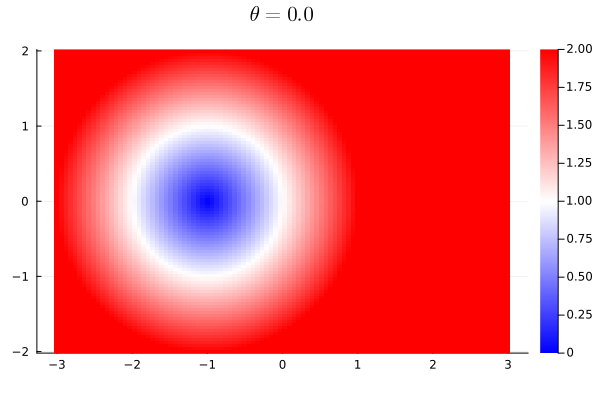

In [49]:
theta = .0
rk_theta(theta) = RKTable([theta], [1]')
rk_theta_endpoint(theta) = RKTable([0 0;1-theta theta], [1-theta theta])
table = rk_theta(theta)
plot_stability(z -> rk_stability(z, table), "\$\\theta = $theta\$")

# Heun's method and RK4

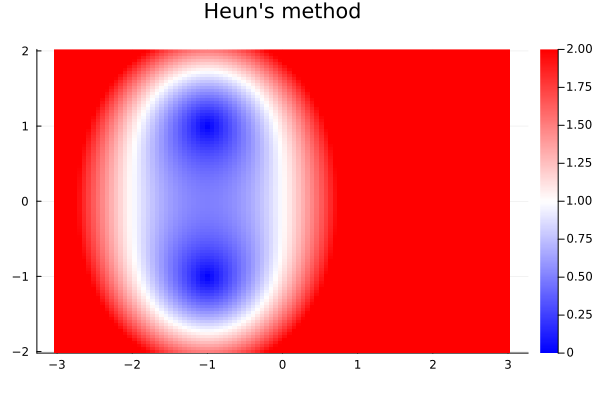

In [50]:
heun = RKTable([0 0; 1 0], [.5 .5])
plot_stability(z -> rk_stability(z, heun), "Heun's method")

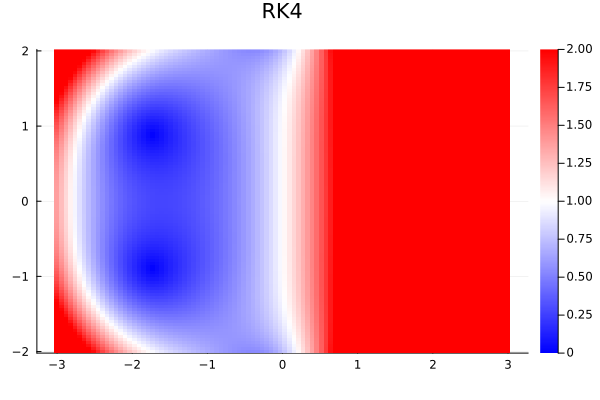

In [51]:
rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0],
[1 2 2 1] / 6)
plot_stability(z -> rk_stability(z, rk4), "RK4")

# An explicit RK solver

\begin{align}
Y_i &= u(t) + h \sum_j a_{ij} f(t+c_j h, Y_j) &
u(t+h) &= u(t) + h \sum_j b_j f(t+c_j h, Y_j)
\end{align}

In [52]:
function ode_rk_explicit(f, u0; tfinal=1, h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b[1,:]
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

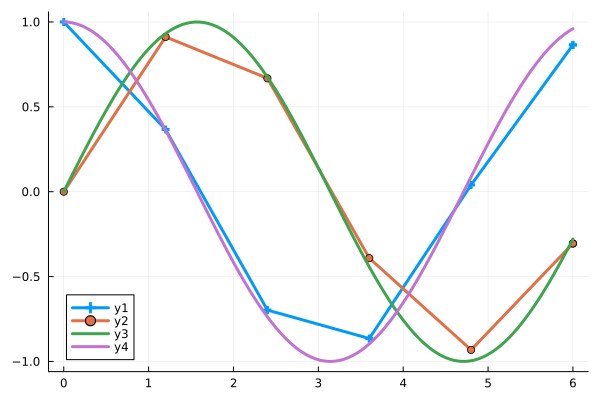

In [53]:
linear_oscillator(t, u) = [0 -1; 1 0] * u
thist, uhist = ode_rk_explicit(linear_oscillator, [1., 0], tfinal=6, h=1.2)
plot(thist, uhist', marker=:auto)
plot!([sin, cos])

# Measuring convergence and accuracy

In [54]:
function mms_error(h, f, u_exact; table=rk4)
    u0 = u_exact(0)
    thist, uhist = ode_rk_explicit(f, u0, tfinal=3, h=h, table=table)
    T = thist[end]
    uhist[:,end] - u_exact(T)
end

hs = .5 .^ (-3:8)
linear_oscillator_exact(t) = [cos(t), sin(t)]

linear_oscillator_exact (generic function with 1 method)

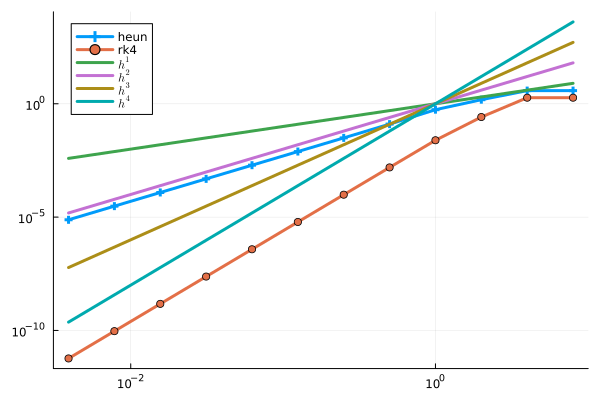

In [55]:
heun_errors = mms_error.(hs, linear_oscillator, linear_oscillator_exact, table=heun)
rk4_errors = mms_error.(hs, linear_oscillator, linear_oscillator_exact, table=rk4)
plot(hs, [norm.(heun_errors) norm.(rk4_errors)], label=["heun" "rk4"], marker=:auto)
plot!(hs, [hs hs.^2 hs.^3 hs.^4], label=["\$h^$p\$" for p in [1 2 3 4]], legend=:topleft, xscale=:log10, yscale=:log10)

# Work-precision (or accuracy vs cost)


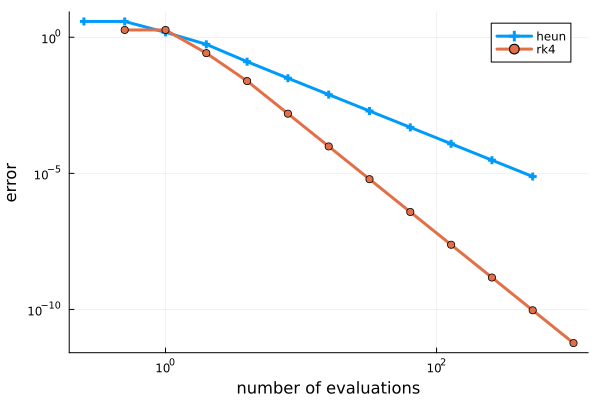

In [56]:
heun_nfeval = length(heun.c) ./ hs
rk4_nfeval = length(rk4.c) ./ hs
plot(heun_nfeval, norm.(heun_errors), marker=:auto, label="heun")
plot!(rk4_nfeval, norm.(rk4_errors), marker=:auto, label="rk4")
plot!(xscale=:log10, yscale=:log10, xlabel="number of evaluations", ylabel="error")

# Effective RK stability diagrams

* Having $s$ stages is like having an effective stepsize of $h/s$ ($s$ "stops along the way"),
* For FSAL methods, $s-1$ effective stages, since last one is reused
* For fair comparison of effort, therefore, scale $z \to sz$ or $z \to (s-1)z$.

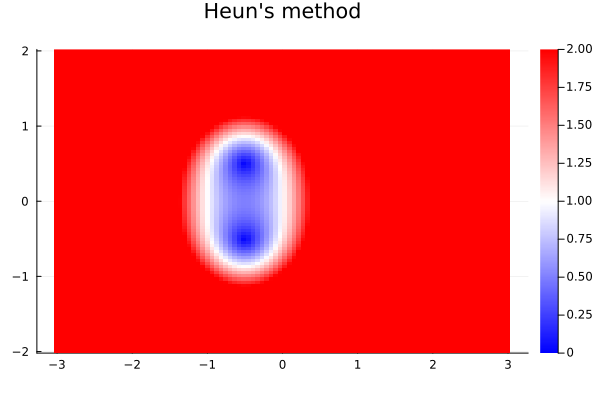

In [60]:
function rk_eff_stability(z, rk; brow=1)
    s = size(rk.b, 2)
    fsal = rk.b[1,:] ≈ rk.A[end,:]
    z = (s - fsal) * z
    1 + z * rk.b[brow,:]' * ((I - z*rk.A) \ ones(s))
end
plot_stability(z -> rk_eff_stability(z, heun), "Heun's method")

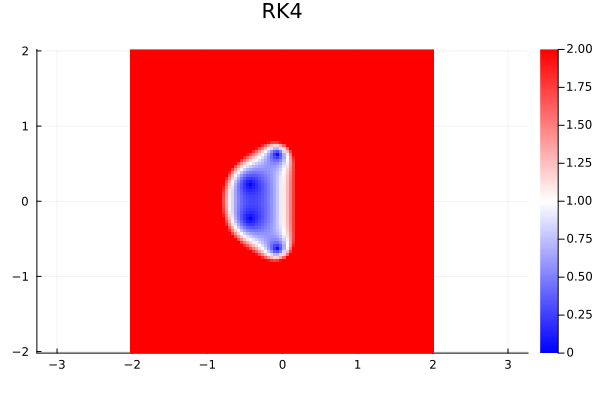

In [61]:
plot_stability(z -> rk_eff_stability(z, rk4), "RK4", xlims=(-2, 2), ylims=(-2, 2))

# Runge-Kutta order conditions

We consider the autonomous differential equation

$$ \dot u = f(u) . $$

Higher derivatives of the exact soultion can be computed using the chain rule, e.g.,

\begin{align*}
\ddot u(t) &= f'(u) \dot u = f'(u) f(u) \\
\dddot u(t) &= f''(u) f(u) f(u) + f'(u) f'(u) f(u) . \\
\end{align*}

Note that if $f(u)$ is linear, $f''(u) = 0$.
Meanwhile, the numerical solution is a function of the time step $h$,

$$\begin{split}
Y_i(h) &= u(0) + h \sum_j a_{ij} f(Y_j) \\
U(h) &= u(0) + h \sum_j b_j f(Y_j).
\end{split}$$

We will take the limit $h\to 0$ and equate derivatives of the numerical solution.  First we differentiate the stage equations,

\begin{split}
Y_i(0) &= u(0) \\
\dot Y_i(0) &= \sum_j a_{ij} f(Y_j) \\
\ddot Y_i(0) &= 2 \sum_j a_{ij} \dot f(Y_j) = 2 \sum_j a_{ij} f'(Y_j) \dot Y_j = 2\sum_{j,k} a_{ij} a_{jk} f'(Y_j) f(Y_k) \\
\dddot Y_i(0) &= 3 \sum_j a_{ij} \ddot f (Y_j) = 3 \sum_j a_{ij} \Big( \sum_k f''(Y_j) \dot Y_j \dot Y_k + f'(Y_j) \ddot Y_j \Big) \\
&= 3 \sum_{j,k,\ell} a_{ij} a_{jk} \Big( a_{j\ell} f''(Y_j) f(Y_k) f(Y_\ell) + 2 a_{k\ell} f'(Y_j) f'(Y_k) f(Y_\ell)  \Big)
\end{split}

where we have used Liebnitz's formula for the $m$th derivative,
$$ (h \phi(h))^{(m)}|_{h=0} = m \phi^{(m-1)}(0) .$$
Similar formulas apply for $\dot U(0)$, $\ddot U(0)$, and $\dddot U(0)$, with $b_j$ in place of $a_{ij}$.

# Order conditions are nonlinear algebraic equations

Equating terms $\dot u(0) = \dot U(0)$ yields
$$ \sum_j b_j = 1, $$
equating $\ddot u(0) = \ddot U(0)$ yields
$$ 2 \sum_{j,k} b_j a_{jk} = 1 , $$
and equating $\dddot u(0) = \dddot U(0)$ yields the two equations
\begin{split}
  3\sum_{j,k,\ell} b_j a_{jk} a_{j\ell} &= 1 \\
  6 \sum_{j,k,\ell} b_j a_{jk} a_{k\ell} &= 1 .
\end{split}

# Observations

* These are systems of nonlinear equations for the coefficients $a_{ij}$ and $b_j$.  There is no guarantee that they have solutions.
* The number of equations grows rapidly as the order increases.

|  | $u^{(1)}$       | $u^{(2)}$   |  $u^{(3)}$ | $u^{(4)}$ | $u^{(5)}$ | $u^{(6)}$ | $u^{(7)}$ | $u^{(8)}$ | $u^{(9)}$ | $u^{(10)}$ |
| ----------- |---|---|---|---|---|----|----|-----|-----|-----|
| # terms     | 1 | 1 | 2 | 4 | 9 | 20 | 48 | 115 | 286 | 719 |
| cumulative | 1 | 2 | 4 | 8 | 17 | 37 | 85 | 200 | 486 | 1205 |

* Usually the number of order conditions does not exactly match the number of free parameters, meaning that the remaining parameters can be optimized (usually numerically) for different purposes, such as to minimize the leading error terms or to maximize stability in certain regions of the complex plane.  Finding globally optimal solutions can be extremely demanding.

* Rooted trees provide a convenient notation

![Trees and elementary differentials up to order 5. From Hairer, Nørsett, and Wanner.](../img/rktrees.png)

# Theorem (from Hairer, Nørsett, and Wanner)

A Runge-Kutta method is of order $p$ if and only if
$$ \gamma(\mathcal t) \sum_{j} b_j \Phi_j(t) = 1 $$
for all trees $t$ of order $\le p$.

For a linear autonomous equation
$$ \dot u = A u $$
we only need one additional order condition per order of accuracy because $f'' = 0$.
These conditions can also be derived by equating derivatives of the stability function $R(z)$ with the exponential $e^z$.
For a linear non-autonomous equation
$$ \dot u = A(t) u + g(t) $$
or more generally, an autonomous system with quadratic right hand side,
$$ \dot u = B (u \otimes u) + A u + C $$
where $B$ is a rank 3 tensor, we have $f''' = 0$, thus limiting the number of order conditions.